In [1]:
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
import time
import matplotlib.pyplot as plt

c_time = time.strftime("%Y%m%d_%H%M%S", time.localtime())
c_time_m = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

In [4]:
# 参数
# ======== System Setup ========
Version = 'V5.1.0-Alpha'
EPOCH = 240
CORE_NUM = 12       # 总运行轮数=EPOCH/CORE_NUM
# ======== Fit Data Input ========
S_N = 417
F_N = 32
N_SAMPLES = 417
INPUT_X = 'Features_'+str(S_N)+'_'+str(F_N)+'.csv'
INPUT_Y = 'Values_ActTotal_'+str(S_N)+'.csv'
INPUT_TITLE = 'Title_'+str(F_N)+'.csv'
INPUT_NAME = 'PepName_'+str(N_SAMPLES)+'.csv'
Ami_Name = 'Feature_Title_3962.csv'
AMI_TITLE = 'Title_566.csv'
AAINDEX = 'aaindex1.csv'
BEGIN_INDEX = 0
END_INDEX_PLUS_ONE = None   # 设为None或者调成0和特征数量，即可使用全部特征
INPUT_SMILES = 'Smiles_'+str(S_N)+'.csv'
# ======== Prediction =========
PREDICT_IN_01 = 'Title_MFF_0_Pred.csv'                      # 字符串，输入的预测用MFF描述符标题文件
PREDICT_IN_02 = 'Title_Desc_8_Pred.csv'                    # 字符串，输入的预测用RDKit描述符标题文件
PREDICT_IN_03 = 'Title_Amino_12_Pred.csv'                    # 字符串，输入的预测用多肽描述符标题文件
# ======== Evolve ========
POP_SIZE = 250                      # 整数，种群大小
RANDOM_SAMPLING = 10                # 整数，每轮产生的新随机个体数
N_GENERATION = 250                  # 整数，进化迭代的轮数
MUTATION_RATE = 0.085               # 浮点数，代表单个数值突变的概率
MATE_RATE = 0.90                    # 浮点数，代表每个父代找到配偶的概率
CROSS_RATE = 0.55                   # 浮点数，代表每个父代的每个数值发生交叉互换的概率
# ======== Split =========
TRAIN_TEST_SPLIT = 0.8
VALIDATION_SPLIT = 0.2  # 将全集随机划分为0.8的训练集和0.2的验证集，其中训练集随机切分0.8的数据用于训练
# ======== Data OutPut ========
VERSION = 'V1.3'
DIR = 'PepScreen_'+VERSION+'_'+c_time
LOG_NAME = 'Log_PepScreen_'+VERSION+'_'+c_time+'.txt'

In [5]:
X = np.loadtxt(INPUT_X, delimiter=',')
title = np.loadtxt(INPUT_TITLE, dtype='str', delimiter=',', comments='!')
y = np.loadtxt(INPUT_Y)
smiles = np.loadtxt(INPUT_SMILES, dtype='str', delimiter=',', comments='!')
pep_name = np.loadtxt(INPUT_NAME, dtype='str', delimiter=',', comments='!')
print('X:', X.shape, '   y:', y.shape)
pred_mff_title = np.loadtxt(PREDICT_IN_01, dtype='str', delimiter=',', comments='!').flatten().tolist()
pred_desc_title = np.loadtxt(PREDICT_IN_02, dtype='str', delimiter=',', comments='!').flatten().tolist()
pred_amino_title = np.loadtxt(PREDICT_IN_03, dtype='str', delimiter=',', comments='!').flatten().tolist()
ve_length = len(pred_mff_title) + len(pred_desc_title) + len(pred_amino_title)
AA_Data = pd.read_csv(AAINDEX)
ami_title = np.loadtxt(AMI_TITLE, dtype='str', delimiter=',', comments='!').flatten().tolist()
# dump_in = np.loadtxt(INPUT_DUMP, dtype='str', delimiter=',', comments='!').reshape(-1, 1)

# point1 = round(X.shape[0]*VALIDATION_SPLIT)
# point2 = round((X.shape[0] - point1) * TRAIN_TEST_SPLIT)
# permutation = np.random.permutation(y.shape[0])
# valid_idx = permutation[:point1]
# train_idx = permutation[point1:point1+point2]
# test_idx = permutation[point1+point2:]
# X_val = X[valid_idx, :]
# y_val = y[valid_idx]
# train_test_idx = np.concatenate((train_idx, test_idx)).reshape(-1)
# X = X[train_test_idx, :]
# y = y[train_test_idx]
# # 打乱数据集
# print('X:', X.shape, '   y:', y.shape)

X: (417, 32)    y: (417,)


/home/jyb/.conda/envs/cyt/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: loadtxt: Empty input file: "Title_MFF_0_Pred.csv"
  import sys


In [6]:
val_index = np.loadtxt('SHAP-GBRT_V1.0cyt_20230509_125646/Valid_index.csv', dtype='int', delimiter=',', comments='!')
X_val = X[val_index, :]
y_val = y[val_index]
train_index = np.loadtxt('SHAP-GBRT_V1.0cyt_20230509_125646/Train_index.csv', dtype='int', delimiter=',', comments='!')
test_index = np.loadtxt('SHAP-GBRT_V1.0cyt_20230509_125646/Test_index.csv', dtype='int', delimiter=',', comments='!')
train_test_index = np.concatenate((train_index, test_index)).reshape(-1)
X = X[train_test_index, :]
y = y[train_test_index]

In [7]:
import os
from pathlib import Path
import joblib
if not os.path.exists(DIR):
    os.mkdir(DIR)
LOG_NAME = Path('.', DIR, LOG_NAME)

In [12]:
from sklearn import model_selection
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from multiprocessing import Pool
import joblib

In [13]:
def draw_scatter_nomral(true_train, pred_train, true_test, pred_test, true_val, pred_val):
    fig = plt.figure(figsize=(7, 7.8), dpi=300)
    ax = fig.add_axes([0.15, 0.09, 0.78, 0.74])
    ax.scatter(true_train, pred_train, s=25, alpha=0.75)
    ax.scatter(true_test, pred_test, s=25, alpha=0.75)
    ax.scatter(true_val, pred_val, s=25, alpha=0.75)
    left_limit = min(min(true_test)-1, min(true_train)-1)
    right_limit = max(max(true_test)+1, max(true_train)+1)
    ax.plot([left_limit, right_limit], [left_limit, right_limit], 'r:')
    ax.plot([left_limit, right_limit], [left_limit+1, right_limit+1], 'y:')
    ax.plot([left_limit, right_limit], [left_limit-1, right_limit-1], 'y:')
    ax.legend(['Train', 'Test', 'Valid', 'Correct', 'Correct+1', 'Correct-1'], loc='upper left', shadow=True, fontsize=17)
    ax.set_xlabel('True Values', fontsize=18)
    ax.set_ylabel('Prediction Values', fontsize=18)
    train_mse = mean_squared_error(true_train, pred_train)
    train_mae = mean_absolute_error(true_train, pred_train)
    train_r2 = r2_score(true_train, pred_train)
    test_mse = mean_squared_error(true_test, pred_test)
    test_mae = mean_absolute_error(true_test, pred_test)
    test_r2 = r2_score(true_test, pred_test)
    val_mse = mean_squared_error(true_val, pred_val)
    val_mae = mean_absolute_error(true_val, pred_val)
    val_r2 = r2_score(true_val, pred_val)
    plt.suptitle('GBRT True-Predict Scatter'+
                 '\nTrain R^2: '+str(round(train_r2, 2))+'  Test R^2: '+str(round(test_r2, 2))+'  Val R^2: '+str(round(val_r2, 2))+
                 '\nTrain MSE: '+str(round(train_mse, 2))+'  Test MSE: '+str(round(test_mse, 2))+'  Val MSE: '+str(round(val_mse, 2))+
                 '\nTrain MAE: '+str(round(train_mae, 2))+'  Test MAE: '+str(round(test_mae, 2))+'  Test MAE: '+str(round(val_mae, 2)), fontsize=18)
    PLOT_NAME3 = str(round(test_r2, 4))+'-R2_GBRT_Scatter_'+c_time+'.png'
    PLOT_NAME3 = Path('.', DIR, PLOT_NAME3)
    plt.savefig(PLOT_NAME3)
    plt.close()

In [14]:
def GBRT_Fit(X, y, X_train, y_train, X_test, y_test, paras):
    clf_new = GradientBoostingRegressor()
    for k, v in paras.items():
        clf_new.set_params(**{k: v})
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # 拟合模型
    clf_new.fit(X_train, y_train)
    # 计算损失
    y_pred = clf_new.predict(X_test)
    y_train_pred = clf_new.predict(X_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae_t = mean_absolute_error(y_train, y_train_pred)
    mse_t = mean_squared_error(y_train, y_train_pred)
    r2_t = r2_score(y_train, y_train_pred)
    temp = [mse, mae, r2, mse_t, mae_t, r2_t]
    print('   MSE: %.5f' % mse, '  MAE: %.5f' % mae, '  R^2: %.5f' % r2)
    return (temp, clf_new)

In [15]:
gbrt_model = GradientBoostingRegressor(n_estimators=200, verbose=0, loss='squared_error', validation_fraction=0.15, n_iter_no_change=50, 
                                tol=0.00025, subsample=0.7538928719433944, warm_start=False, learning_rate=10**(-1.3445093241536106), min_impurity_decrease=0.002804794644669451, 
                                max_depth=10, max_features=0.35801348562560875, max_leaf_nodes=14)    
paras = gbrt_model.get_params()
mse_list = []
mae_list = []
r2_list = []
mse_t_list = []
mae_t_list = []
r2_t_list = []
r2_list_val = []

In [16]:
best_regressors = []
kf = KFold(n_splits=10)
pool = Pool(CORE_NUM)
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'n_estimators': [50, 100, 150, 200],
# }
# param_grid = {
#         'n_estimators':[50, 100, 150, 200],
#         'max_depth':[3, 4, 5],
#         'learning_rate':[0.1, 0.01, 0.05],
#         'subsample':np.linspace(0.7,0.9,3),
#         'colsample_bytree':np.linspace(0.3,0.98,3),
# }
# Add grid search cv to find the best parameters
# grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, scoring='neg_mean_absolute_error')
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_regressors.append(grid_search.best_estimator_)

regressors = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    # Define the XGB regressor model with detailed parameters
#     xgb_model = XGBRegressor()
#     xgb_model = XGBRegressor(**best_params)
    
    # Define the parameter grid for grid search cv
    r = pool.apply_async(GBRT_Fit, args=(X, y, X_train, y_train, X_test, y_test, paras,))
    results = r.get()
    temp = results[0]
    mse = temp[0]
    mae = temp[1]
    r2 = temp[2]
    mse_t = temp[3]
    mae_t = temp[4]
    r2_t = temp[5]
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)
    mse_t_list.append(mse_t)
    mae_t_list.append(mae_t)
    r2_t_list.append(r2_t)
    gbrt_model = results[1]
    # Save the estimator
    pred_train = gbrt_model.predict(X_train)
    pred_test = gbrt_model.predict(X_test)
    pred_val = gbrt_model.predict(X_val)
    true_train = y_train.flatten().tolist()
    true_test = y_test.flatten().tolist()
    true_val = y_val.flatten().tolist()
#     print('r2_train:{:.2f}'.format(r2_score(y_train, pred_train))+'    mae_train:{:.2f}'.format(mean_absolute_error(y_train, pred_train)))
#     print('r2_test:{:.2f}'.format(r2_score(y_test, pred_test))+'    mae_test:{:.2f}'.format(mean_absolute_error(y_test, pred_test)))
    draw_scatter_nomral(true_train, pred_train, true_test, pred_test, true_val, pred_val)
    regressors.append(results[1])

# Define a Gaussian distribution using the mean and std value
# from scipy.stats import norm
# likelihoods = []
# for i in range(len(regressors)):
#     pdf_value = norm.pdf(y_valid, y_preds[i], y_preds_std)
#     likelihoods.append(pdf_value)

   MSE: 0.14832   MAE: 0.31687   R^2: 0.37417
   MSE: 0.08615   MAE: 0.23588   R^2: 0.63364
   MSE: 0.15439   MAE: 0.31809   R^2: 0.31739
   MSE: 0.11829   MAE: 0.27277   R^2: 0.51298
   MSE: 0.09236   MAE: 0.24727   R^2: 0.58687
   MSE: 0.12968   MAE: 0.29715   R^2: 0.26809
   MSE: 0.14551   MAE: 0.28763   R^2: 0.31937
   MSE: 0.11324   MAE: 0.26963   R^2: 0.44704
   MSE: 0.17141   MAE: 0.32322   R^2: 0.26001
   MSE: 0.13125   MAE: 0.29980   R^2: 0.46214


In [18]:
# Use list comprehension to make predictions on X_val for each regressor in the regressors list
y_preds = [regressor.predict(X_val) for regressor in regressors]
# Use numpy to calculate the mean and standard deviation of the predictions on X_val for each regressor in the regressors list
y_preds_mean = np.mean(y_preds, axis=0)
y_preds_std = np.std(y_preds, axis=0)
for i in range(len(y_preds)):
    print('r2_valid:{:.2f}'.format(r2_score(y_val, y_preds[i]))+'    mae_valid:{:.2f}'.format(mean_absolute_error(y_val, y_preds[i])))

r2_valid:0.51    mae_valid:0.30
r2_valid:0.46    mae_valid:0.30
r2_valid:0.39    mae_valid:0.32
r2_valid:0.38    mae_valid:0.33
r2_valid:0.48    mae_valid:0.30
r2_valid:0.48    mae_valid:0.30
r2_valid:0.53    mae_valid:0.28
r2_valid:0.46    mae_valid:0.31
r2_valid:0.47    mae_valid:0.29
r2_valid:0.40    mae_valid:0.31


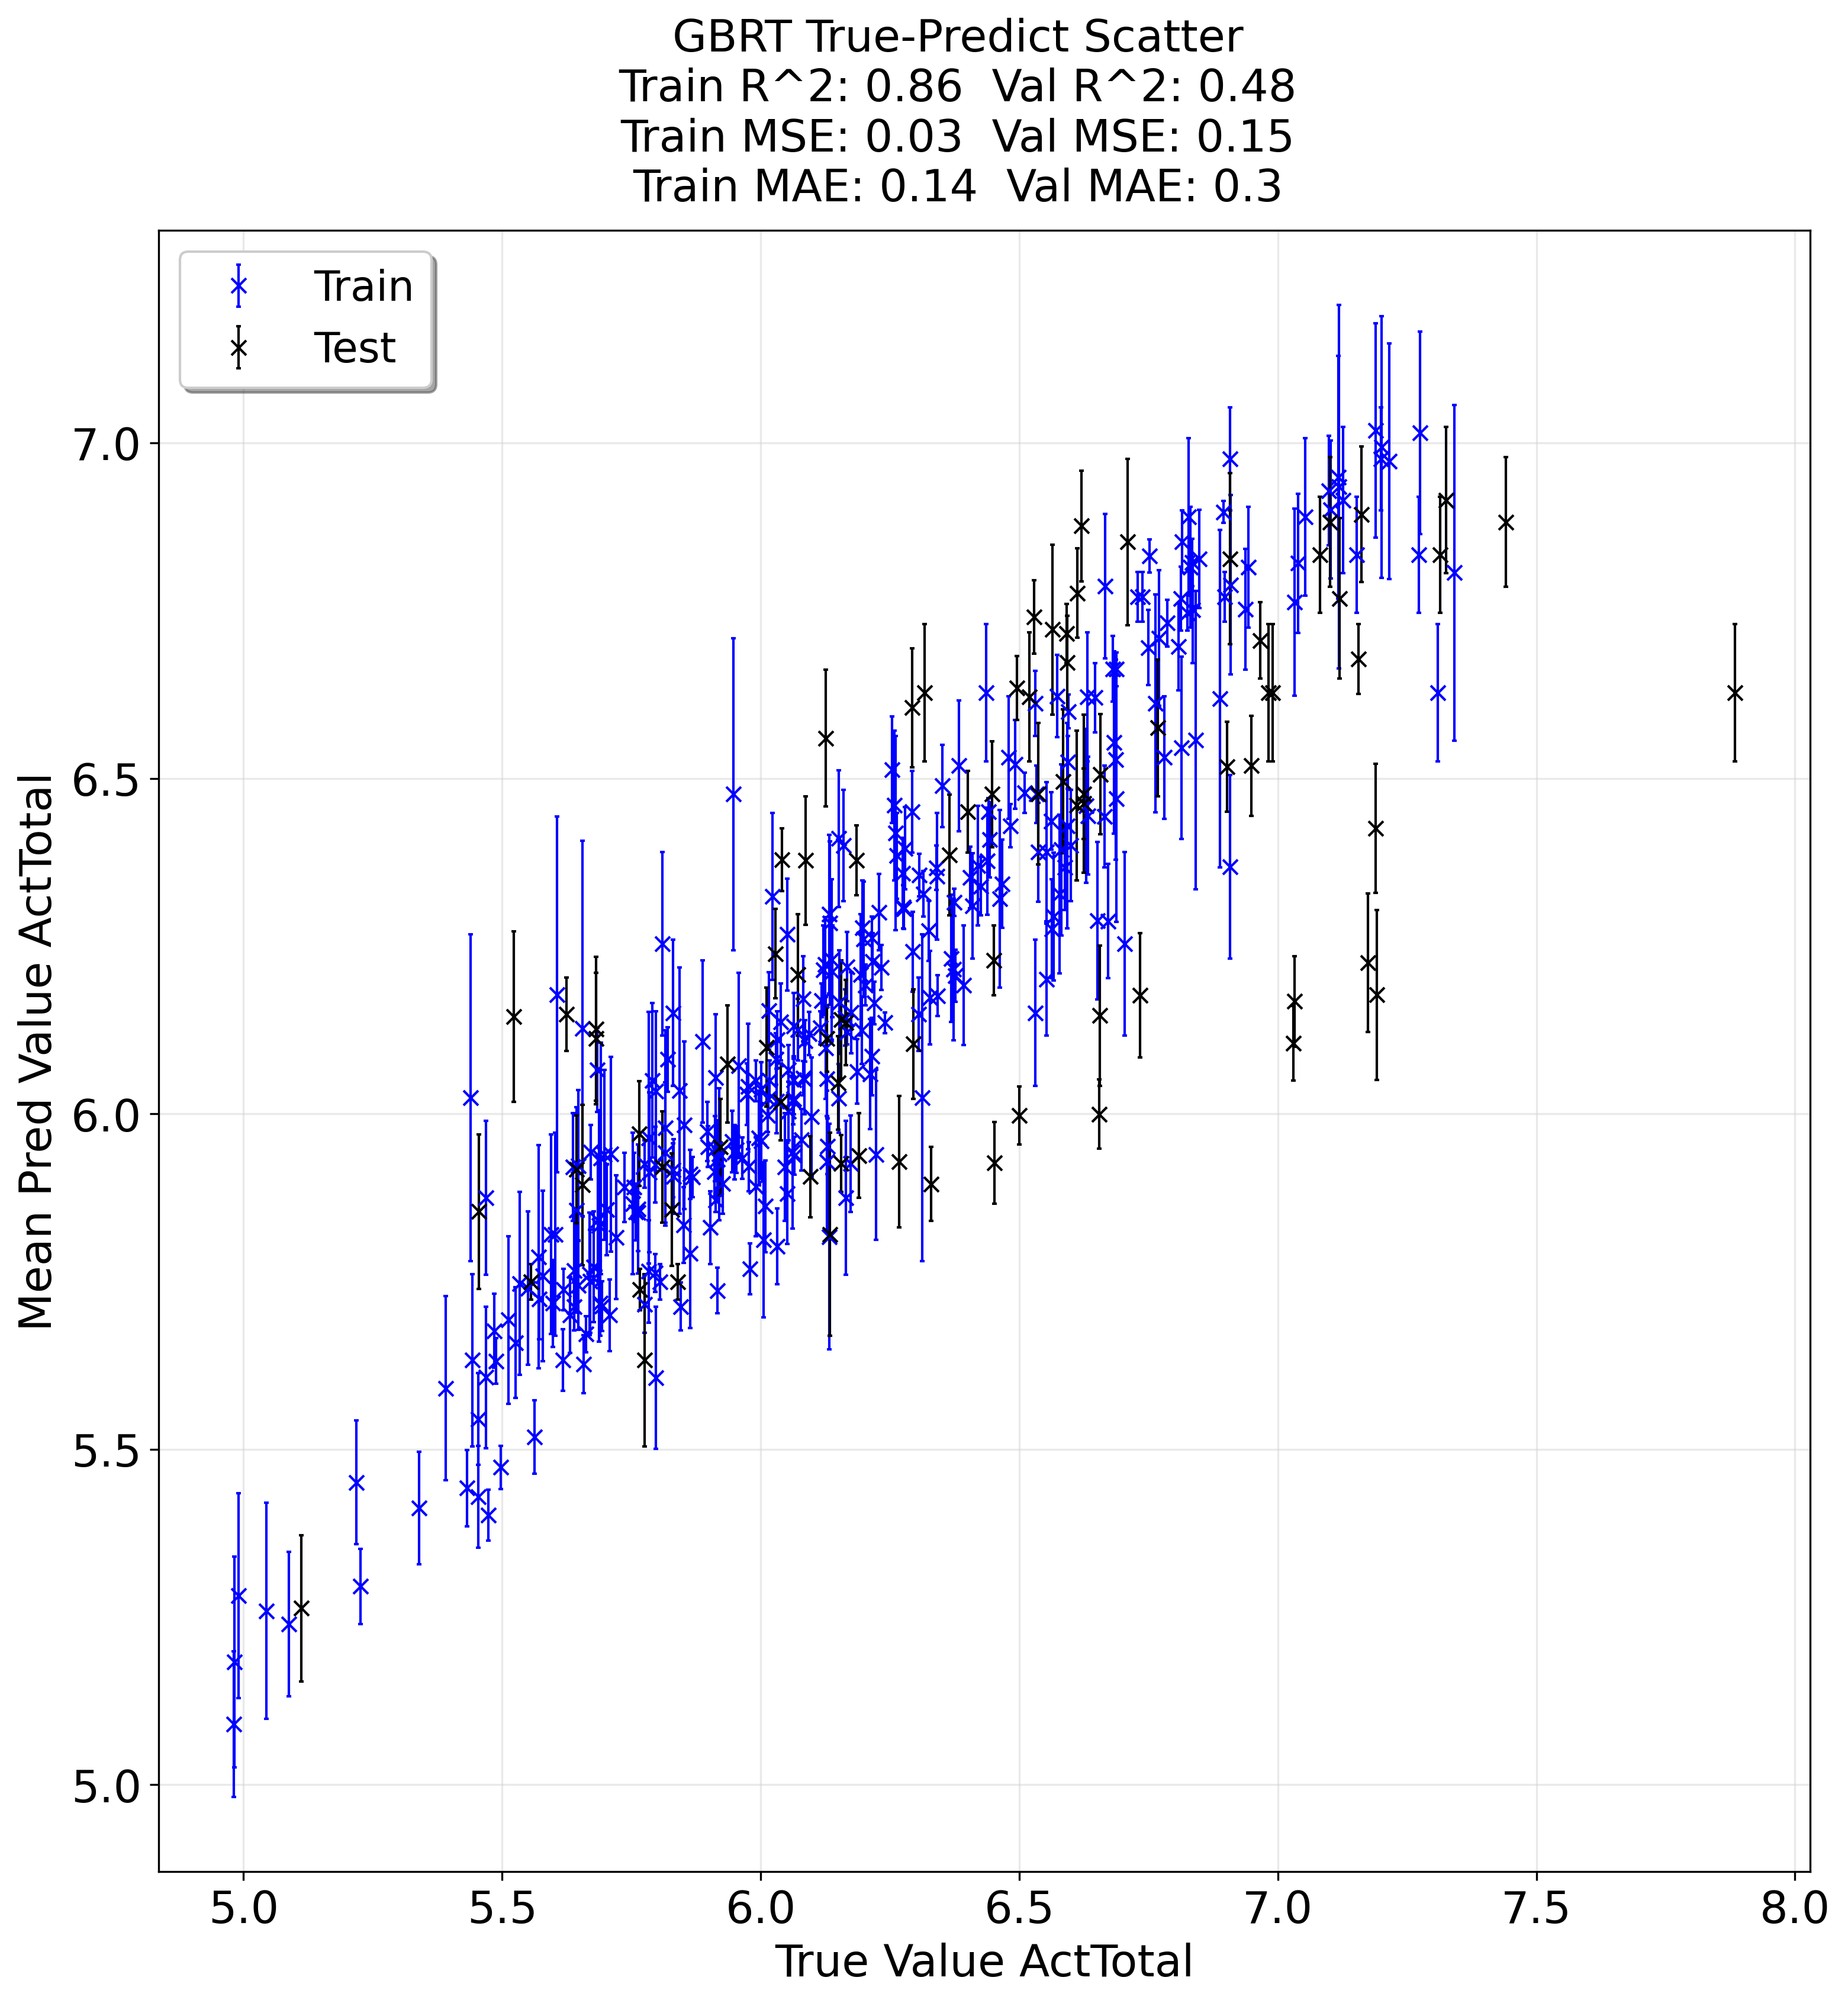

In [21]:
# 绘制图像
y_pred_value_train = []
y_train_variance = []
y_pred_value_val = []
y_val_variance = []
for i in range(X_train.shape[0]):
    value1 = [regressor.predict(X_train[i, :].reshape(1, -1)) for regressor in regressors]
    y_pred_value_train.append(np.mean(value1))
    y_train_variance.append(np.std(value1))
for i in range(X_val.shape[0]):
    value4 = [regressor.predict(X_val[i, :].reshape(1, -1)) for regressor in regressors]
    y_pred_value_val.append(np.mean(value4))
    y_val_variance.append(np.std(value4))
    
train_r2 = r2_score(y_train,  y_pred_value_train)
train_mae = mean_absolute_error(y_train,  y_pred_value_train)
train_mse = mean_squared_error(y_train,  y_pred_value_train)
val_r2 = r2_score(y_val,  y_pred_value_val)
val_mae = mean_absolute_error(y_val,  y_pred_value_val)
val_mse = mean_squared_error(y_val,  y_pred_value_val)
    
plt.figure(figsize=(12, 12), dpi=300)
plt.errorbar(y_train,  y_pred_value_train, yerr=y_train_variance, fmt='x', color='b', elinewidth=1, ecolor='blue', capsize=1)
plt.errorbar(y_val,  y_pred_value_val, yerr=y_val_variance, fmt='x', color='black', elinewidth=1, ecolor='black', capsize=1)
plt.grid(which='major', color='#D5D5D5', alpha=0.5, zorder=1)
plt.ylabel('Mean Pred Value ActTotal', fontsize=18)
plt.xlabel('True Value ActTotal', fontsize=18)
plt.legend(['Train', 'Test', 'Val', 'Recommend'], loc='upper left', shadow=True, fontsize=17)
plt.yticks(size=18)
plt.xticks(size=18)
plt.suptitle( 'GBRT True-Predict Scatter'+
             '\nTrain R^2: '+str(round(train_r2, 2))+'  Val R^2: '+str(round(val_r2, 2))+
             '\nTrain MSE: '+str(round(train_mse, 2))+'  Val MSE: '+str(round(val_mse, 2))+
             '\nTrain MAE: '+str(round(train_mae, 2))+'  Val MAE: '+str(round(val_mae, 2)), 
             fontsize=18)
FIGNAME = 'pred_vs_true_of_ActTotal.png'
FIGNAME = Path('.', DIR, FIGNAME)
plt.savefig(FIGNAME)
plt.show()

In [12]:
# 定义氨基酸字符库：
ac_m = ['G', 'A', 'V', 'L', 'I', 'M', 'C', 'T', 'S', 'N', 'Q', 'D', 'E', 'F', 'Y', 'W', 'H', 'P', 'K', 'R']

ac_ref = {'G':1, 'A':2, 'V':3, 'L':4, 'I':5, 
          'M':6, 'C':7, 'T':8, 'S':9, 'N':10, 
          'Q':11, 'D':12, 'E':13, 'F':14, 'Y':15, 
          'W':16, 'H':17, 'P':18, 'K':19, 'R':20, 'O':0}

ac_ref_inv = {}
for key, value in ac_ref.items():
    ac_ref_inv[value] = key

# DNA是一个7长度的列表，无氨基酸的位置为0，有氨基酸的位置为1-21
A_list = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7']
Desc_list = ['AASI', 'ABHPRK', 'argos', 'bulkiness', 'charge_phys', 'charge_acid',
             'cougar', 'eisenberg', 'Ez', 'flexibility', 'grantham', 'gravy', 'hopp-woods', 'ISAECI', 'janin', 'kytedoolittle', 'levitt_alpha',
            'MSS', 'MSW', 'pepArc', 'pepcats', 'polarity', 'PPCALI', 'refractivity', 't_scale', 'TM_tend', 'z3', 'z5']
Ami_list = np.loadtxt(Ami_Name, dtype=str, delimiter=',', comments='!')

In [13]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from modlamp.descriptors import PeptideDescriptor

In [14]:
descriptors = []
descList = []
for descriptor, function in Descriptors.descList:
    if descriptor in pred_desc_title:
        descriptors.append(descriptor)
        descList.append((descriptor, function))

In [15]:
def featurization_ve(smi_in, helm_in, dna_in):
    global ve_length, pred_mff_title, pred_desc_title, descList, ac_ref, ac_ref_inv
    pep = ''
    for i in dna_in:
        if i != 0:
            pep += ac_ref_inv[int(i)]
    pep_ = pep
    ve = np.zeros((1, ve_length))
    mol = Chem.MolFromSmiles(smi_in)
    index = -1
    for i in range(len(pred_mff_title)):
        index += 1
        f = pred_mff_title[i]
        patt = Chem.MolFromSmarts(f)
        ve[0, index] = len(mol.GetSubstructMatches(patt))
    for desc_name, function in descList:
        index += 1
        ve[0, index] = function(mol)
    for i in pred_amino_title:
        if i in A_list:
            pos = int(i[1]) - 1
            amino = helm_in.split('.')
            if len(amino) >= pos + 1:
                index += 1
                ve[0, index] = ac_ref[amino[pos]]
        elif i == 'Amino_Length':
            index += 1
            ve[0, index] = np.count_nonzero(dna_ina)
        elif i in Desc_list:
            index += 1
            desc = PeptideDescriptor([pep], i)
            desc.calculate_global(window=1000, modality='mean')
            ve[0, index] = desc.descriptor
        elif i in Ami_list:
            index += 1
            while len(pep) < int(i[1]):
                pep += 'O'
            ve[0, index] = AA_Data.loc[ami_title.index(i[3:])][pep[int(i[1])-1]]
    return ve

In [16]:
def translate(dna_in):
    global ac_m
    s = 'PEPTIDE1{'
    s_temp = ''
    for i in range(len(dna_in)):
        if dna_in[i] != 0:
            s_temp += ac_m[int(dna_in[i]-1)]
            s += ac_m[int(dna_in[i]-1)]
            if i != len(dna_in)-1 and dna_in[i+1] != 0:
                s += '.'
                s_temp += '.'
    s += '}$$$$'
    mol = Chem.MolFromHELM(s)
    smi = Chem.MolToSmiles(mol)
    ve = featurization_ve(smi, s_temp, dna_in)
    return ve

In [17]:
def get_true_fitness(X):
    X_v = translate(X)
    y_preds = [regressor.predict(X_v) for regressor in regressors]
    y_preds_mean = np.mean(y_preds, axis=0)
    y_preds_std = np.std(y_preds, axis=0)
    y_pred = np.array([y_preds_mean, y_preds_std])
    return y_pred.reshape(-1)

In [18]:
def get_UCB_fitness(X, k):
    X = translate(X)
    y_preds = [regressor.predict(X) for regressor in regressors]
    y_preds_mean = np.mean(y_preds, axis=0)
    y_preds_std = np.std(y_preds, axis=0)
    ucb = k * y_preds_std + y_preds_mean
    return y_preds_std

In [19]:
# DNA查错
def dna_check(dna_in):
    dna_out = np.zeros((7, 1))
    index = -1
    for i in range(7):
        if dna_in[i] != 0:
            index += 1
            dna_out[index] = dna_in[i]
    dna_out = dna_out.flatten().tolist()
    return dna_out

In [20]:
# 父代突变
def mutation(dna_in, child_fitness=None, fitness=None):
    dna_temp = dna_in.copy()
    for i in range(len(dna_in)):
        if np.random.rand()<=MUTATION_RATE:
            dna_temp[i] = np.random.randint(0, 20, dtype=int)
    dt = dna_check(dna_temp)
    return dt

In [21]:
# 父代交叉互换
def cross(parent, pop, parent_index=None, fitness=None):
    child = parent.copy()
    if np.random.rand()<=MATE_RATE:
        mate_index = np.random.randint(len(pop))
        mate = pop[mate_index]
        for j in range(len(parent)):
            if np.random.rand()<=CROSS_RATE:
                child[j] = mate[j]
    c = dna_check(child)
    return c

In [22]:
# 自然选择
def select(pop, fitness):
    global fitness_t
    new_pop = []
    score = []
    index = np.argsort(-np.array(fitness)).flatten().tolist()
#     for i in index:
#         print(fitness[i])
    for i in range(POP_SIZE-RANDOM_SAMPLING):
        new_pop.append(pop[index[i]])
        # score.append(fitness[index[i]])
    for i in range(RANDOM_SAMPLING):
        new_parent = []
        for j in range(7):
            new_parent.append(np.random.randint(0, 20, dtype=int))
        new_pop.append(dna_check(new_parent))
        # score.append(get_fitness(new_parent))
    return new_pop

In [23]:
import operator
def unique_pop(pop):
    pop_temp = []
    for i in range(len(pop)):
        flag = True
        for l_temp in pop_temp:
            if operator.eq(l_temp, pop[i]):
                flag = False
                break
        if flag:
            pop_temp.append(pop[i])
    return pop_temp

In [24]:
def write_peptide(dna_in):
    s = ''
    for i in range(len(dna_in)):
        if dna_in[i] != 0:
            s += ac_m[int(dna_in[i]-1)]
            if i != len(dna_in)-1 and dna_in[i+1] != 0:
                s += '.'
    return s

Population size: 250
Generation 1 is evolving.
Length of pop (with children): 500
Length of pop (with children): 484 (After unique)
Generation 1 is done!  End time: 2023.04.30 15:51:27
Best Fitness(Max): 0.19082564115524292  Mean Fitness: 0.08629032550764477
~~Time used: 8.678 sec ,ETA: 2160.779 sec ( 36.013 min )~~

Generation 2 is evolving.
Length of pop (with children): 500
Length of pop (with children): 486 (After unique)
Generation 2 is done!  End time: 2023.04.30 15:51:35
Best Fitness(Max): 0.19082564115524292  Mean Fitness: 0.0981463925384077
~~Time used: 8.659 sec ,ETA: 2149.760 sec ( 35.829 min )~~

Generation 3 is evolving.
Length of pop (with children): 500
Length of pop (with children): 477 (After unique)
Generation 3 is done!  End time: 2023.04.30 15:51:44
Best Fitness(Max): 0.19082564115524292  Mean Fitness: 0.10291304957098181
~~Time used: 8.460 sec ,ETA: 2123.925 sec ( 35.399 min )~~

Generation 4 is evolving.
Length of pop (with children): 500
Length of pop (with child

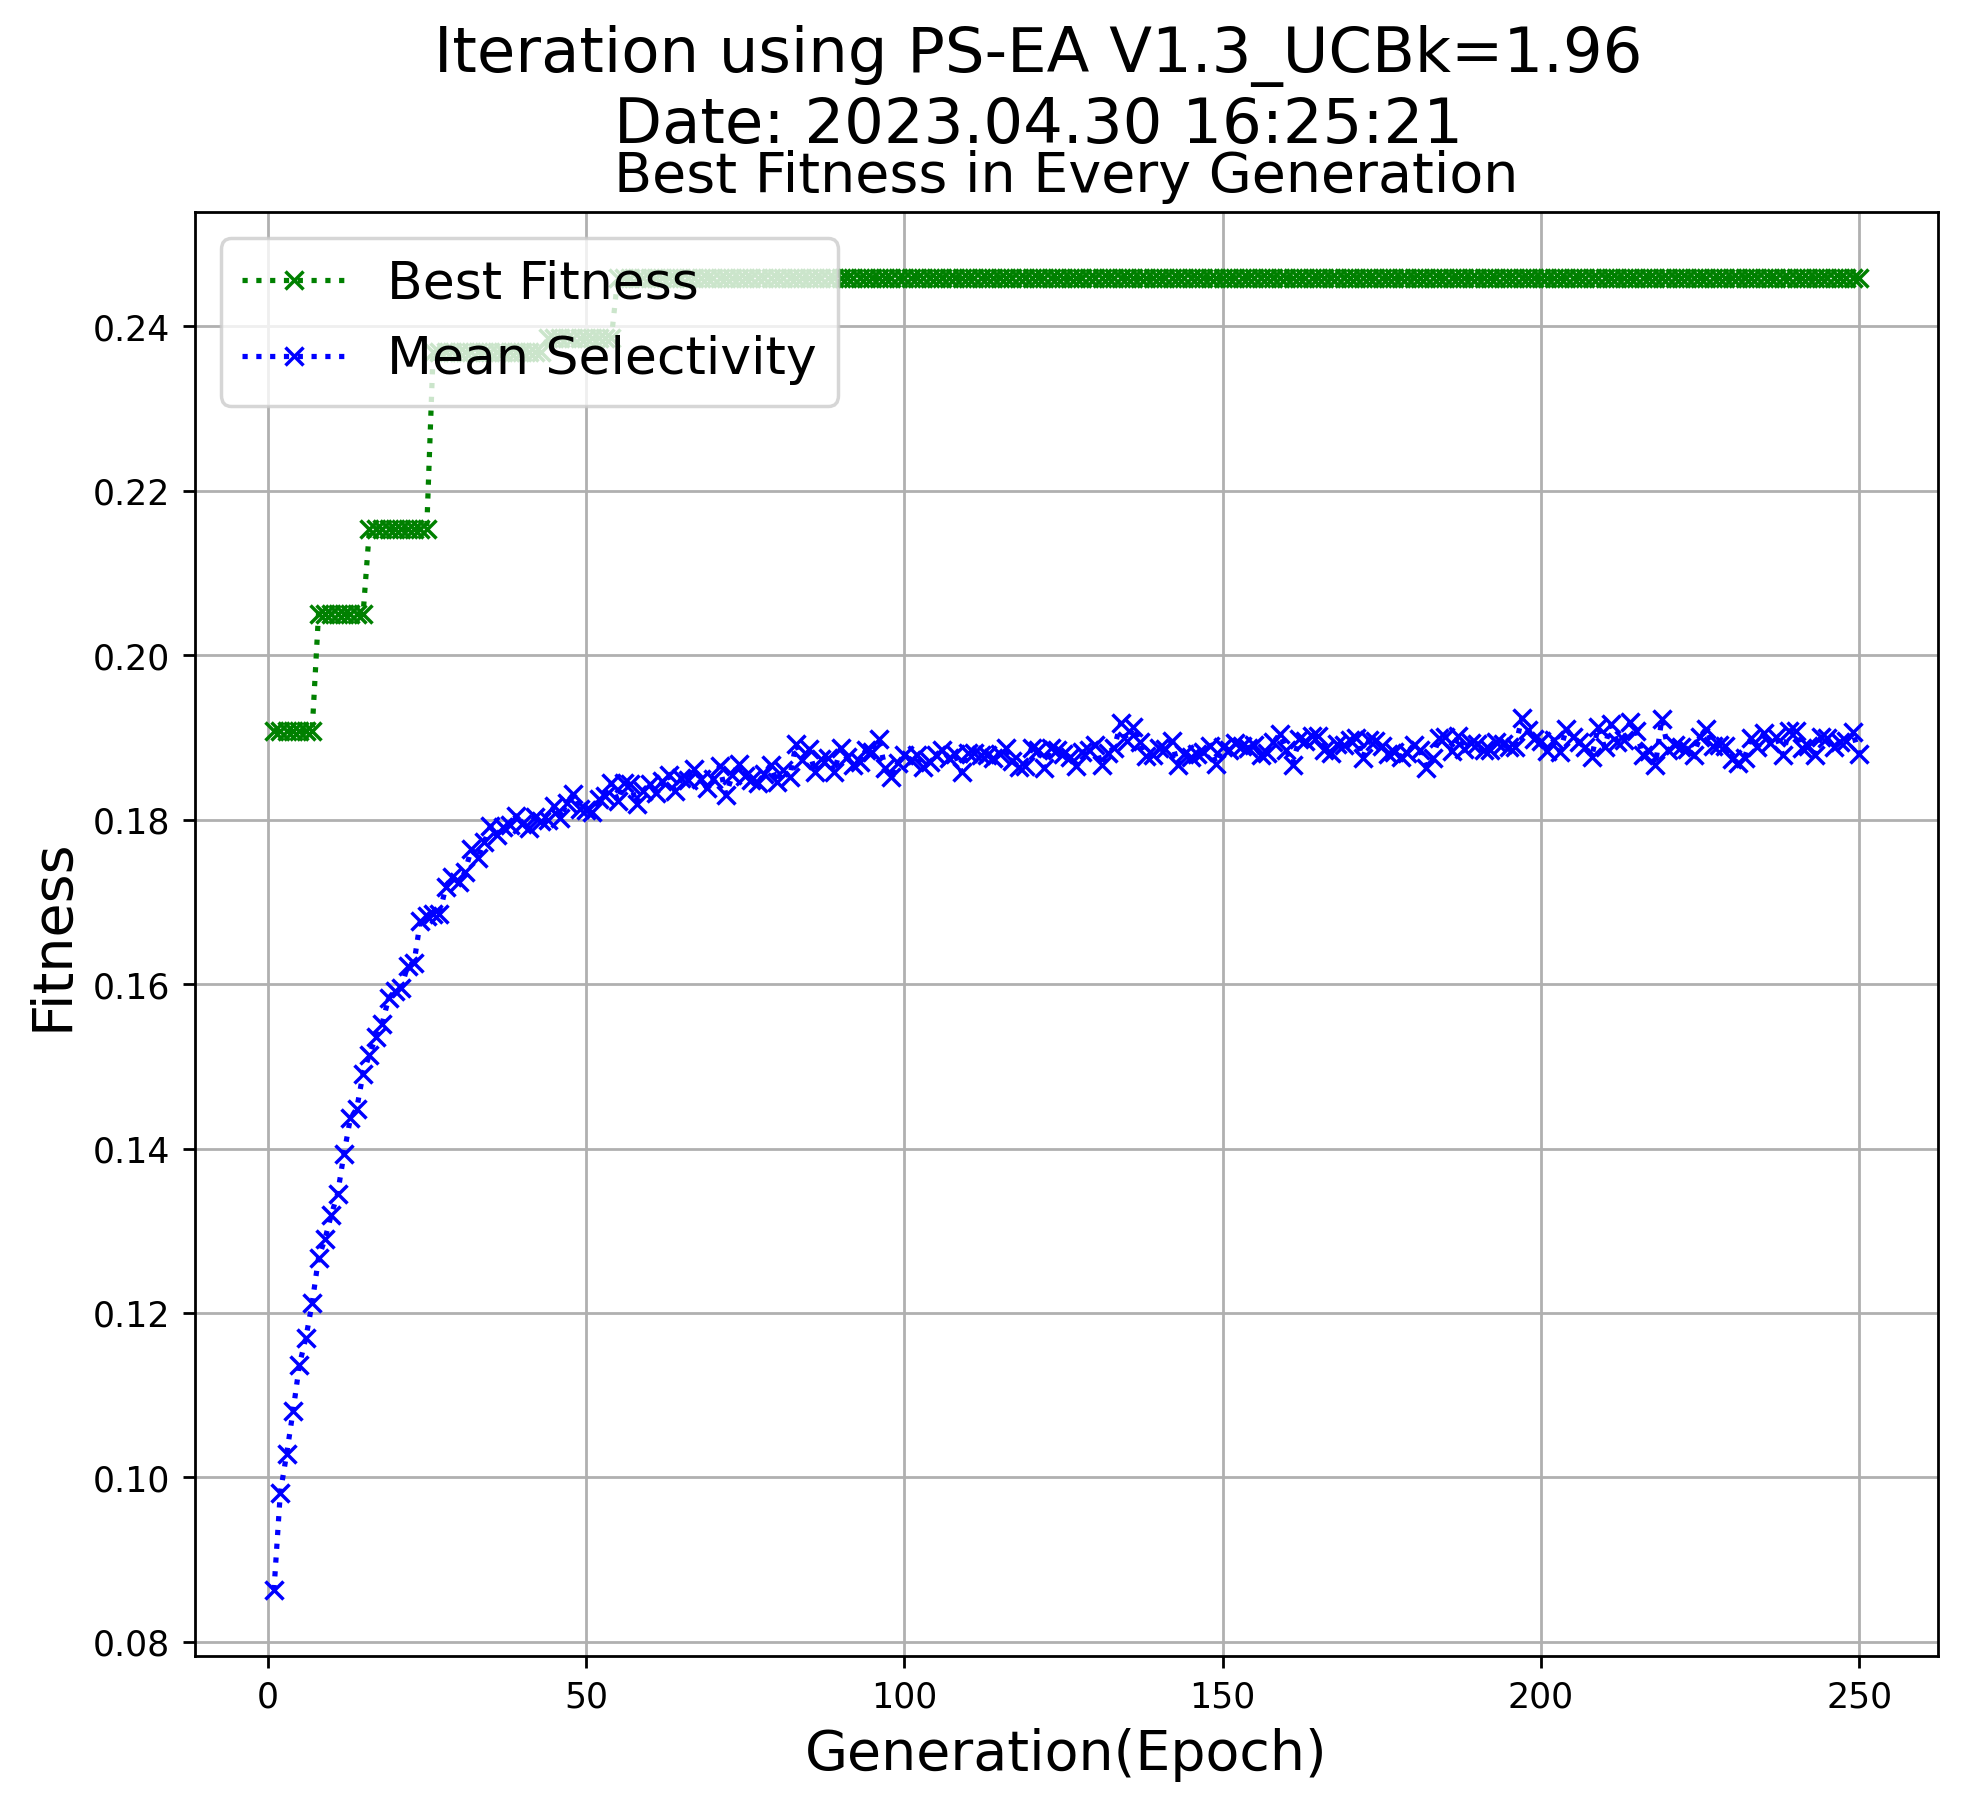

In [25]:
# for ungreedy_factor in np.linspace(0, 1.96, 12):
ungreedy_factor = 1.96
# 创建种群
population = []
for i in range(POP_SIZE):
    parent = []
    for j in range(7):
        parent.append(np.random.randint(0, 20, dtype=int))
    population.append(dna_check(parent))
print('Population size:', len(population))

# 输出文件命名
RECORD_NAME = 'Record_PepScreen_'+VERSION+'_'+'UCBk={:.2f}'.format(ungreedy_factor)+'_'+c_time+'.txt'
RECORD_NAME = Path('.', DIR, RECORD_NAME)
# 迭代进化
f2 = open(RECORD_NAME, 'w+')
f2.write('Record of CRCC-EA:\n\n')
f2.write('Evolution Start Time: '+time.strftime("%Y.%m.%d %H:%M:%S", time.localtime())+'\n\n')
max_score_list = []  # 储存每一代中适应度的最大值
mean_score_list = []  # 储存每一代中适应度的平均值
eta=[]
close_flag = True
for _ in range(N_GENERATION):
    start_time = time.time()
    print('Generation', _+1, 'is evolving.')
    f2.write('Generation '+str(_+1)+' is evolving.\n')
    fitness = []
    pop_copy = population.copy()
    child_list = []
    f2.write('Population Size: '+str(len(pop_copy))+'\n')
    for parent_index in range(len(population)):
        parent = population[parent_index]
        # 交叉互换
        child = cross(parent, population)
        # 突变
        child_m = mutation(child)
        child_list.append(child_m)
    # 合并
    for c_t in child_list:
        pop_copy.append(c_t)
    print('Length of pop (with children):', len(pop_copy))
    # 除重
    pop_copy = unique_pop(pop_copy)
    print('Length of pop (with children):', len(pop_copy), '(After unique)')
    f2.write(str(len(pop_copy))+' indivials remaining after unique.\n')
    # 计算适应度
    fitness = np.zeros((len(pop_copy,)))
    for i in range(len(pop_copy)):
        fitness[i] = get_UCB_fitness(pop_copy[i], ungreedy_factor)
    # 自然选择
    population = select(pop_copy, fitness)

    max_score_list.append(max(fitness))
    mean_score_list.append(np.mean(fitness))
    f2.write('Best Fitness(Max): '+str(max(fitness))+'    Mean Fitness: '+str(np.mean(fitness))+'\n')

    f2.write('Best 5 dna:\n')
    for i in range(5):
        f2.write('  Peptide Sequence: '+write_peptide(population[i])+'\n')
    time_use = time.time()-start_time
    eta.append(time_use)
    eta_time = np.mean(eta)*(N_GENERATION-_-1)
    f2.write('Time use: '+str(time_use)+' sec'+'    ETA: '+str(eta_time)+' sec ( '+str(eta_time/60)+' min )\n')
    print('Generation', _+1, 'is done!  End time:', time.strftime("%Y.%m.%d %H:%M:%S", time.localtime()))
    print('Best Fitness(Max):', max(fitness), ' Mean Fitness:', np.mean(fitness))

    print('~~Time used: %.3f sec' % time_use, ',ETA: %.3f sec ( %.3f min )~~\n' %(eta_time, eta_time/60))
    f2.write('Generation '+str(_+1)+' is done at '+time.strftime("%Y.%m.%d_%H:%M:%S", time.localtime())+'\n\n')

# 与原始数据比较除重
pop_u = []
for i in range(len(population)):
    dna_in = population[i]
    if write_peptide(dna_in) not in pep_name:
        pop_u.append(dna_in)

# 排序，准备输出
f_list = np.zeros((len(pop_u), 2))
for i in range(len(pop_u)):
    f_list[i, 0] = get_true_fitness(pop_u[i])[0]
    f_list[i, 1] = get_true_fitness(pop_u[i])[1]
sel_list = f_list[:, 0]
p_sorted = np.argsort(-np.array(sel_list))  # 按照选择性排序

# 输出需要的个体
out = []
for k in range(len(pop_u)):
    out.append([write_peptide(pop_u[p_sorted[k]]), str(f_list[p_sorted[k], 0]), str(f_list[p_sorted[k], 1])])
out = np.array(out)
save_name = Path('.', DIR, 'Recommend_'+str(len(pop_u))+'_'+'UCBk={:.2f}'.format(ungreedy_factor)+'.csv')
np.savetxt(save_name, out, fmt='%s', delimiter=',')

# 绘制进化图像
PLOT_NAME = 'Selectivity_Plot_PepScreen_'+VERSION+'_'+'UCBk={:.2f}'.format(ungreedy_factor)+'_'+c_time+'.png'
PLOT_NAME = Path('.', DIR, PLOT_NAME)
SUPTITLE = 'Iteration using PS-EA '+VERSION+'_'+'UCBk={:.2f}'.format(ungreedy_factor)+\
'\nDate: '+time.strftime("%Y.%m.%d %H:%M:%S", time.localtime())+'\n\n'
#绘制&保存
x1_index = np.linspace(1, len(max_score_list), len(max_score_list))
x2_index = np.linspace(1, len(mean_score_list), len(mean_score_list))
plt.figure(figsize=(9,7.5), dpi=250)
plt.title(' \nBest Fitness in Every Generation', fontsize=16)
plt.plot(x2_index, max_score_list, color='g', linestyle=':', marker = 'x', markersize = 5)
plt.plot(x2_index, mean_score_list, color='b', linestyle=':', marker = 'x', markersize = 5)
plt.grid(True)
plt.legend(['Best Fitness', 'Mean Selectivity'], loc='upper left', fontsize=15)
plt.ylabel('Fitness', fontsize=16)
plt.xlabel('Generation(Epoch)', fontsize=16)
plt.suptitle(SUPTITLE, fontsize=18)
plt.savefig(PLOT_NAME, bbox_inches='tight')

In [31]:
# 最远点采样
def prepare_sequence(pep_name):
    global ac_ref
    pep_list = []
    for i in range(len(pep_name)):
        pep = pep_name[i].split('.')
        while len(pep) <= 6:
            pep.append('O')
        pep_list.append(pep)
    for j in pep_list:
        for k in range(len(j)):
            j[k] = ac_ref[j[k]]
    pep_array = np.array(pep_list)
    return pep_array
# 读取输出的pep
rec_list = []
# for ungreedy_factor in np.linspace(0, 1.96, 12):
ungreedy_factor = 1.96
File_name = 'Recommend_250_UCBk={:.2f}.csv'.format(ungreedy_factor)
File_name = Path('.', DIR, File_name)
rec_pep = np.loadtxt(File_name, dtype='str', delimiter=',', comments='!')
rec_list.append(rec_pep[:100, :].tolist())
pep_i = [i for rec in rec_list for i in rec]
pep_in = np.array(pep_i)

recommended_list = prepare_sequence(pep_in[:, 0])
feature_mat = np.zeros((len(pep_in), 7))
for i in range(len(pep_in)):
    feature_mat[i, :] = recommended_list[i, :]
    
# 0-1归一化
def scaling(feature_mat_in):
    feature_mat_out = np.zeros(feature_mat_in.shape)
    for i in range(feature_mat_in.shape[1]):
        feature_mat_out[:, i] = (feature_mat_in[:, i] - np.min(feature_mat_in[:, i]) + 1e-10) / \
        (np.max(feature_mat_in[:, i]) - np.min(feature_mat_in[:, i]) + 1e-10)
    return feature_mat_out
# 计算欧式距离
def cal_dist(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

feature_mat_scaled = scaling(feature_mat)

def farthest_point_sample(feature_mat_scaled, n_points, init_method='farthest_from_center'):
    ind_selected_list = [] # 储存被选中的序列索引
    ind_list = list(range(feature_mat_scaled.shape[0])) # 储存未被选择的点
    # 随机初始化
    if init_method == 'random':
        init_ind = np.random.randint(feature_mat_scaled.shape[0])
    # 最远点初始化
    if init_method == 'farthest_from_center':
        center = np.mean(feature_mat_scaled, axis=0)
        dist = 0
        ind = 0
        for i in ind_list:
            dist_i = cal_dist(feature_mat_scaled[i, :], center)
            if dist_i > dist:
                ind = i
        init_ind = ind
        
    ind_selected_list.append(init_ind)
    ind_list.remove(init_ind)
    
    for i in range(n_points - 1):
        dist_selected_set = []
        for ind in ind_list:
            dist = 100
            for ind_selected in ind_selected_list:
                dist_i = cal_dist(feature_mat_scaled[ind_selected, :], feature_mat_scaled[ind, :])
                if dist_i < dist:
                    dist = dist_i
            dist_selected_set.append(dist)
        max_ind = dist_selected_set.index(np.max(dist_selected_set))
        ind_selected_list.append(ind_list[max_ind])
        ind_list.pop(max_ind)
    return ind_selected_list

NUM_REC = 12
selected_index = farthest_point_sample(feature_mat_scaled, NUM_REC)
feature_selected = feature_mat[selected_index, :]
recommended_selected = recommended_list[selected_index, :]
value_selected = pep_in[selected_index, 1:]

out = []
for _ in range(NUM_REC):
    out.append([write_peptide(recommended_selected[_]), value_selected[_, 0], value_selected[_, 1]])
out = np.array(out)
save_name = 'Recommend_Selected_'+str(NUM_REC)+'.csv'
save_name = Path('.', DIR, save_name)
np.savetxt(save_name, out, fmt='%s', delimiter=',')

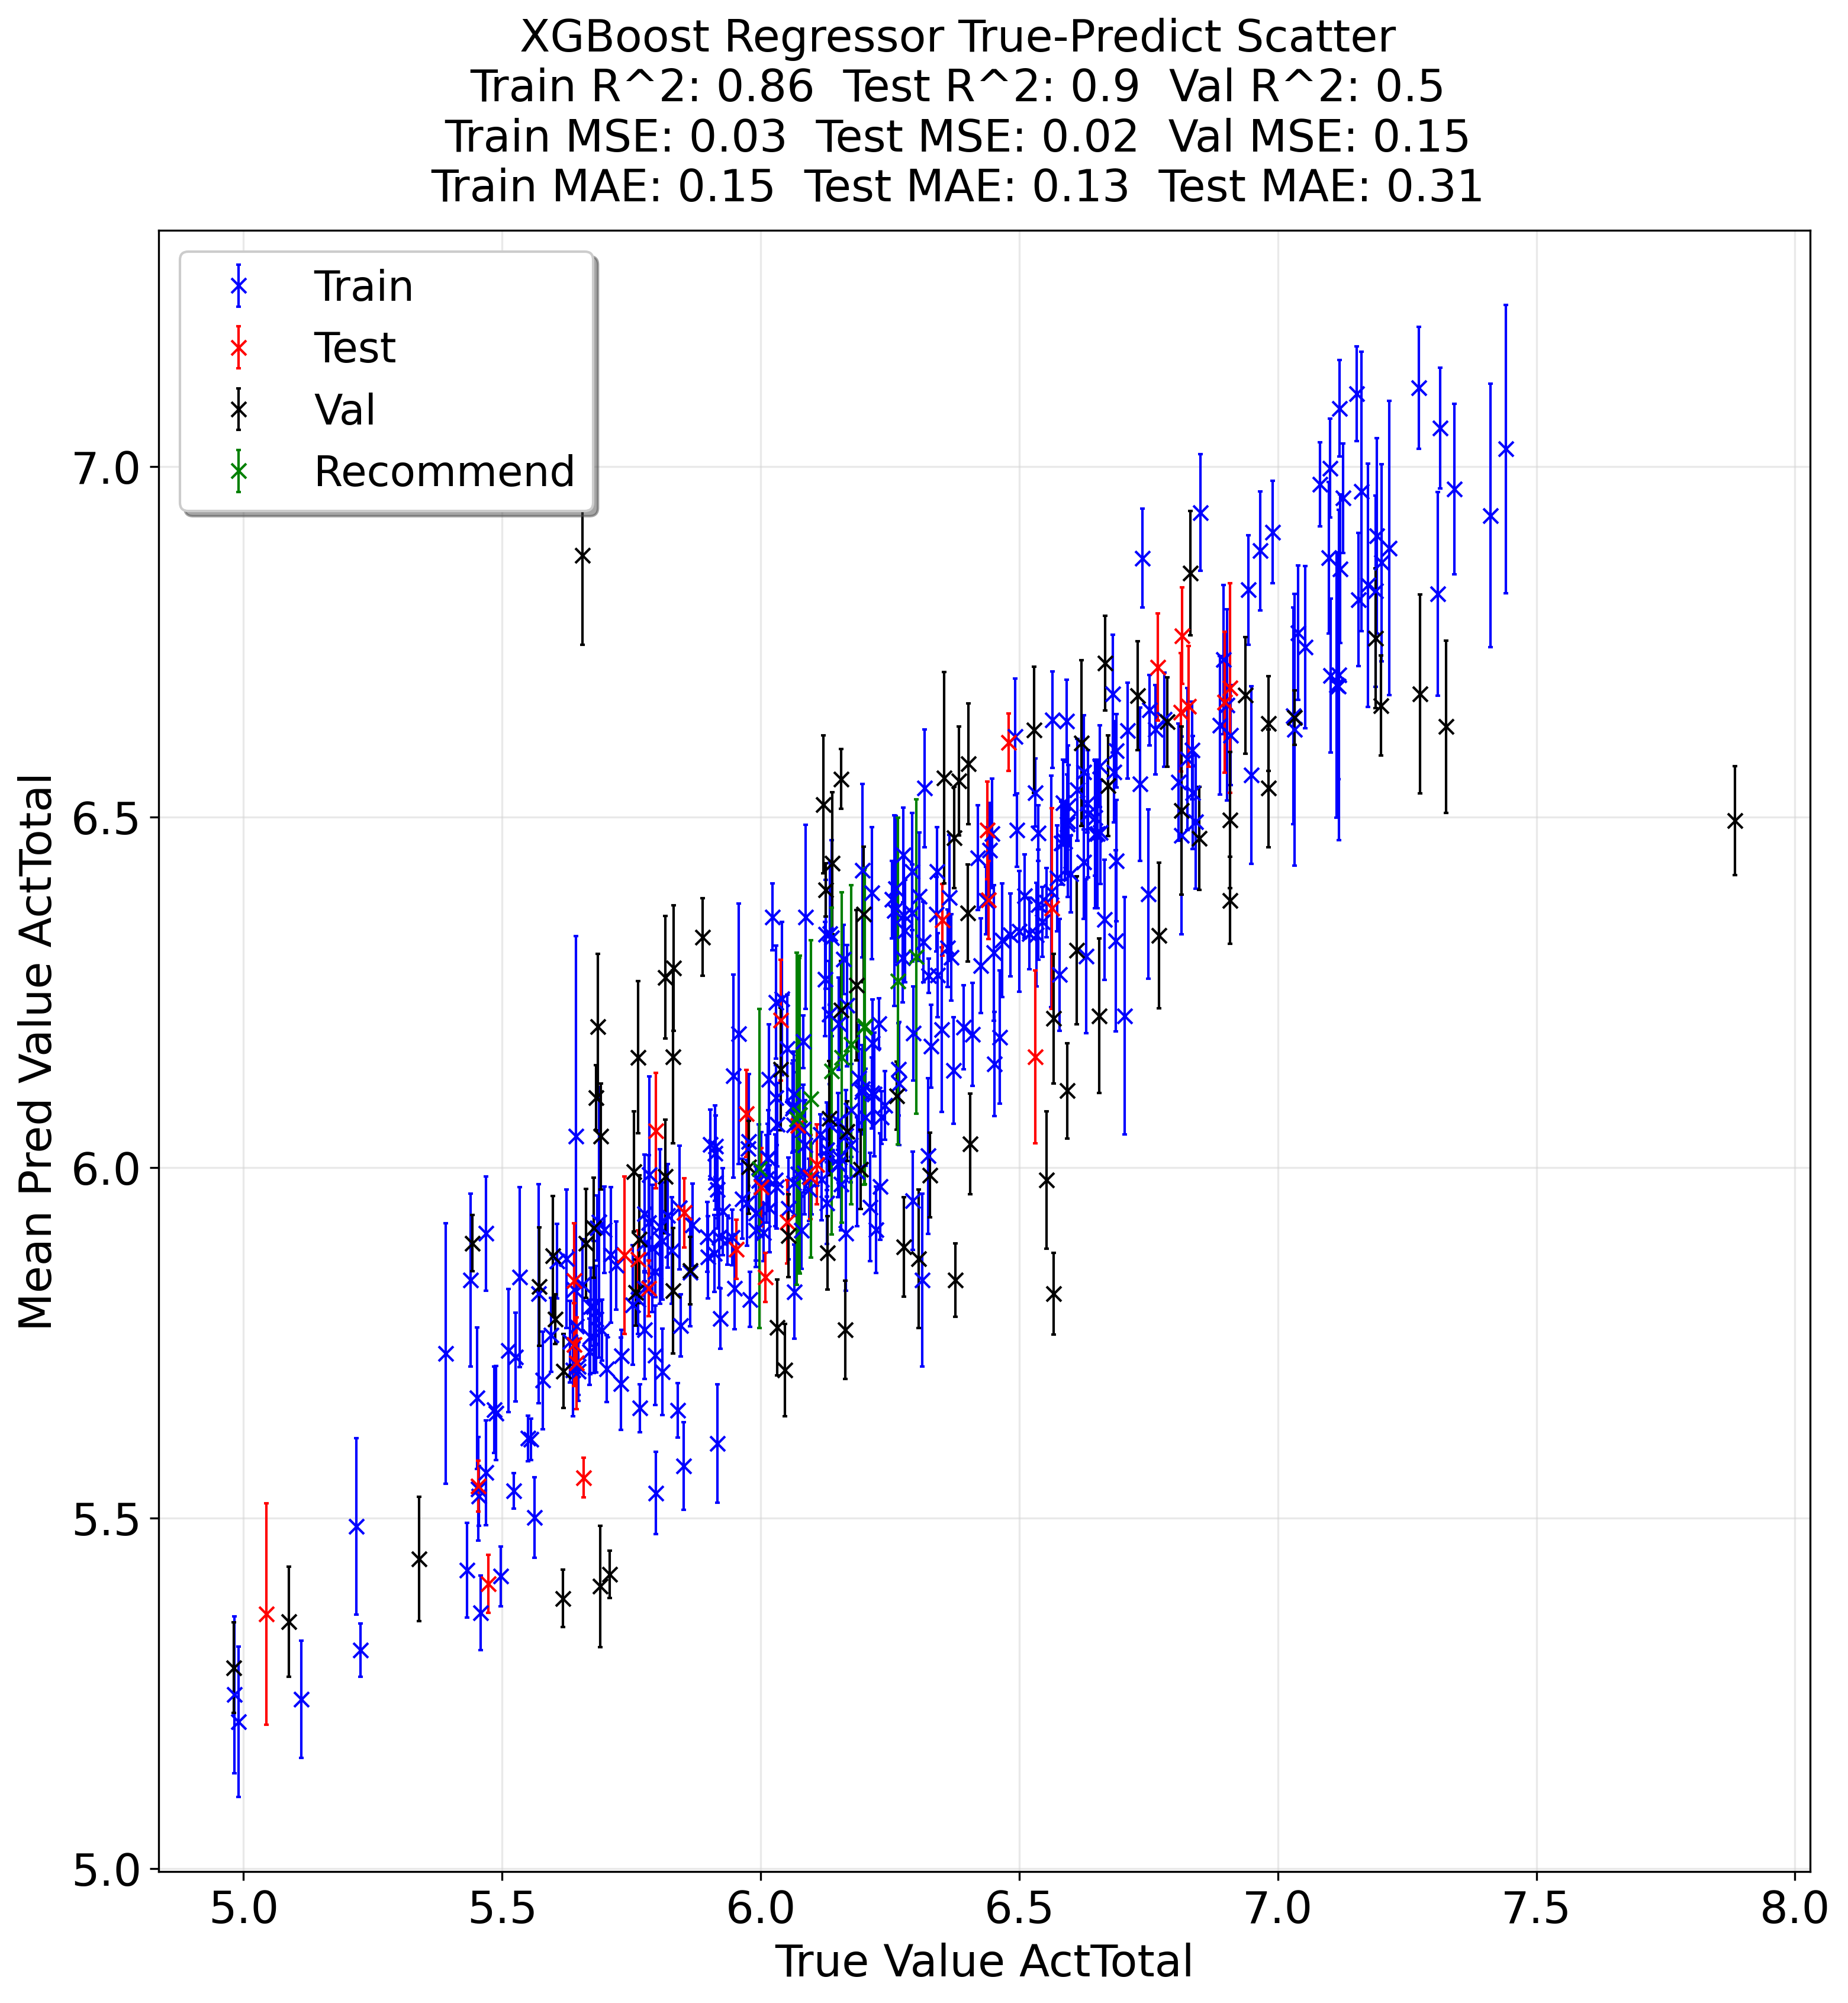

In [32]:
# 绘制图像
y_pred_value_train = []
y_train_variance = []
y_pred_value_test = []
y_test_variance = []
y_pred_value_val = []
y_val_variance = []
recommend_y = []
recommend_y_var = []
for i in range(X_train.shape[0]):
    value1 = [regressor.predict(X_train[i, :].reshape(-1, 20)) for regressor in regressors]
    y_pred_value_train.append(np.mean(value1))
    y_train_variance.append(np.std(value1))
for i in range(X_test.shape[0]):
    value2 = [regressor.predict(X_test[i, :].reshape(-1, 20)) for regressor in regressors]
    y_pred_value_test.append(np.mean(value2))
    y_test_variance.append(np.std(value2))
for i in range(X_val.shape[0]):
    value4 = [regressor.predict(X_val[i, :].reshape(-1, 20)) for regressor in regressors]
    y_pred_value_val.append(np.mean(value4))
    y_val_variance.append(np.std(value4))
for i in range(NUM_REC):
    value3 = get_true_fitness(recommended_selected[i])
    recommend_y.append(value3[0])
    recommend_y_var.append(value3[1])
    
train_r2 = r2_score(y_train,  y_pred_value_train)
train_mae = mean_absolute_error(y_train,  y_pred_value_train)
train_mse = mean_squared_error(y_train,  y_pred_value_train)
test_r2 = r2_score(y_test,  y_pred_value_test)
test_mae = mean_absolute_error(y_test,  y_pred_value_test)
test_mse = mean_squared_error(y_test,  y_pred_value_test)
val_r2 = r2_score(y_val,  y_pred_value_val)
val_mae = mean_absolute_error(y_val,  y_pred_value_val)
val_mse = mean_squared_error(y_val,  y_pred_value_val)
    
plt.figure(figsize=(12, 12), dpi=300)
plt.errorbar(y_train,  y_pred_value_train, yerr=y_train_variance, fmt='x', color='b', elinewidth=1, ecolor='blue', capsize=1)
plt.errorbar(y_test,  y_pred_value_test, yerr=y_test_variance, fmt='x', color='r', elinewidth=1, ecolor='red', capsize=1)
plt.errorbar(y_val,  y_pred_value_val, yerr=y_val_variance, fmt='x', color='black', elinewidth=1, ecolor='black', capsize=1)
plt.errorbar(recommend_y,  recommend_y, yerr=recommend_y_var, fmt='x', color='g', elinewidth=1, ecolor='green', capsize=1)
plt.grid(which='major', color='#D5D5D5', alpha=0.5, zorder=1)
plt.ylabel('Mean Pred Value ActTotal', fontsize=18)
plt.xlabel('True Value ActTotal', fontsize=18)
plt.legend(['Train', 'Test', 'Val', 'Recommend'], loc='upper left', shadow=True, fontsize=17)
plt.yticks(size=18)
plt.xticks(size=18)
plt.suptitle('GBRT True-Predict Scatter'+
             '\nTrain R^2: '+str(round(train_r2, 2))+'  Test R^2: '+str(round(test_r2, 2))+'  Val R^2: '+str(round(val_r2, 2))+
             '\nTrain MSE: '+str(round(train_mse, 2))+'  Test MSE: '+str(round(test_mse, 2))+'  Val MSE: '+str(round(val_mse, 2))+
             '\nTrain MAE: '+str(round(train_mae, 2))+'  Test MAE: '+str(round(test_mae, 2))+'  Test MAE: '+str(round(val_mae, 2)), 
             fontsize=18)
FIGNAME = 'pred_vs_true_of_ActTotal.png'
FIGNAME = Path('.', DIR, FIGNAME)
plt.savefig(FIGNAME)
plt.show()